2023.11.19
尝试使用PyTorch内置ViT分类模型

In [1]:
%matplotlib inline
import os
os.environ['TORCH_HOME'] = 'weights'

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

import argparse
# 用于jupyter实时绘图
import pylab as pl
from IPython import display

In [2]:
""" 定义超参 """
# parser = argparse.ArgumentParser(description='ViT分类模型 2023.11.19')
# parser.add_argument('--batch', default=256, help='')

# opt = parser.parse_args()
# print(opt)

EPOCHS = 100
BATCH = 64
NUM_WORKERS = 4
DROP_LAST = True
LR = 0.005

In [3]:
""" 构建数据集 """
process_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]),        # int 图片短边会缩放到int，长边相应缩放，不是我们想要的正方形
])
# CIFAR10 32x32 colour images in 10 classes
train_dataset = torchvision.datasets.CIFAR10(root='../data/', train=True, transform=process_data, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../data/', transform=process_data, download=True)
train_iter = DataLoader(dataset=train_dataset, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, drop_last=DROP_LAST)
test_iter = DataLoader(dataset=test_dataset, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, drop_last=DROP_LAST)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
""" 定义ViT_model """
ViT_model = torchvision.models.vit_b_16()
ViT_model.heads = nn.Linear(768, train_dataset.classes.__len__())
""" 测试ViT输入输出 """
with torch.no_grad():
    ViT_model.eval()        # 影响BN、dropout层
    x = torch.rand(size=(10, 3, 224, 224))
    y = ViT_model(x)
    print(y.softmax(dim=-1), torch.argmax(torch.softmax(y, dim=-1), dim=-1), sep='\n')

tensor([[0.0300, 0.0642, 0.0659, 0.0755, 0.0855, 0.0769, 0.1848, 0.1382, 0.1476,
         0.1313],
        [0.0297, 0.0615, 0.0664, 0.0769, 0.0828, 0.0770, 0.1801, 0.1380, 0.1582,
         0.1295],
        [0.0295, 0.0626, 0.0645, 0.0725, 0.0855, 0.0761, 0.1902, 0.1313, 0.1560,
         0.1318],
        [0.0292, 0.0605, 0.0655, 0.0720, 0.0873, 0.0784, 0.1808, 0.1413, 0.1595,
         0.1256],
        [0.0288, 0.0621, 0.0669, 0.0723, 0.0860, 0.0736, 0.1864, 0.1373, 0.1566,
         0.1300],
        [0.0301, 0.0624, 0.0647, 0.0727, 0.0844, 0.0711, 0.1868, 0.1359, 0.1589,
         0.1330],
        [0.0294, 0.0644, 0.0652, 0.0754, 0.0882, 0.0741, 0.1850, 0.1388, 0.1499,
         0.1298],
        [0.0287, 0.0632, 0.0667, 0.0739, 0.0873, 0.0745, 0.1842, 0.1418, 0.1556,
         0.1241],
        [0.0304, 0.0635, 0.0630, 0.0793, 0.0871, 0.0746, 0.1794, 0.1379, 0.1491,
         0.1357],
        [0.0293, 0.0636, 0.0633, 0.0727, 0.0882, 0.0733, 0.1873, 0.1333, 0.1557,
         0.1332]])
tensor([6

In [ ]:
""" 定义loss、optim """
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=ViT_model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=train_iter.__len__())

In [ ]:
def evaluate(model, test_iter, device):
    """ 使用验证集评估模型 """
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for i, (x, y) in enumerate(test_iter):
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            correct += torch.sum(y_hat.softmax(dim=-1).argmax(dim=-1) == y)
            total += x.shape[0]
            acc = correct / total
            print(f'---------->evaluate {i}/{len(test_iter)} acc:{acc.item() * 100:.7f}% ')
        return acc.item()

epoch 0/100 iter 253/781 lr 0.0038133 acc 17.6612% 


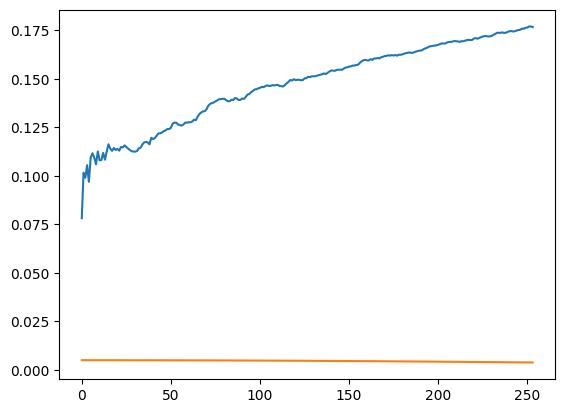

In [ ]:
""" 训练 """
lr_iter = []
acc_iter = []
correct = 0
total = 0
iter = 0
device = torch.device('mps')
ViT_model.to(device=device)
for epoch in range(EPOCHS):
    ViT_model.train()               # 切换到train模式
    for i, (x, y) in enumerate(train_iter):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = ViT_model(x)
        # 统计精度
        correct += torch.sum(y_hat.softmax(dim=-1).argmax(dim=-1) == y)
        total += x.shape[0]
        acc = correct / total
        acc_iter.append(acc.item())
        lr_iter.append(scheduler.get_last_lr()[0])
        iter += 1
        print(f'epoch {epoch}/{EPOCHS} iter {i}/{len(train_iter)} lr {lr_iter[-1]:.7f} acc {acc * 100:.4f}% ')
        # backward update
        loss = loss_func(y_hat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # draw acc
        pl.clf()
        pl.plot(acc_iter)
        pl.plot(lr_iter)
        display.display(pl.gcf())
        display.clear_output(True)
    # evalute model
    _ = evaluate(ViT_model, test_iter, device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
ViT_model.to(torch.device('mps'))
evaluate(ViT_model, test_iter, torch.device('mps'))

/Users/sunchengcheng/miniconda3/envs/pt20/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/sunchengcheng/miniconda3/envs/pt20/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change f

---------->evaluate acc:4.6875000% 
---------->evaluate acc:5.4687500% 
---------->evaluate acc:6.2500000% 
---------->evaluate acc:6.6406250% 
---------->evaluate acc:7.1874999% 
---------->evaluate acc:8.3333336% 
---------->evaluate acc:9.1517858% 
---------->evaluate acc:9.7656250% 
---------->evaluate acc:9.3750000% 
---------->evaluate acc:10.0000001% 
---------->evaluate acc:10.2272727% 
---------->evaluate acc:10.5468750% 
---------->evaluate acc:10.3365384% 
---------->evaluate acc:9.9330358% 
---------->evaluate acc:10.0000001% 
---------->evaluate acc:9.8632812% 
---------->evaluate acc:9.5588237% 
---------->evaluate acc:9.6354164% 
---------->evaluate acc:9.8684214% 
---------->evaluate acc:10.0781247% 
---------->evaluate acc:10.1190478% 
---------->evaluate acc:9.9431820% 
---------->evaluate acc:10.0543477% 
---------->evaluate acc:10.0911461% 
---------->evaluate acc:10.0625001% 
---------->evaluate acc:9.9759616% 
---------->evaluate acc:10.1273149% 
---------->evalua